# Stable Diffusion

Stable diffusion v1.5 is a text-to-image generative model from 2022. The model can be downloaded from huggingface and is relatively small for a text-to-image model.

In [1]:
#!pip install --quiet diffusers
#!pip install --quiet transformers

In [2]:
from diffusers import StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/50 [00:00<?, ?it/s]

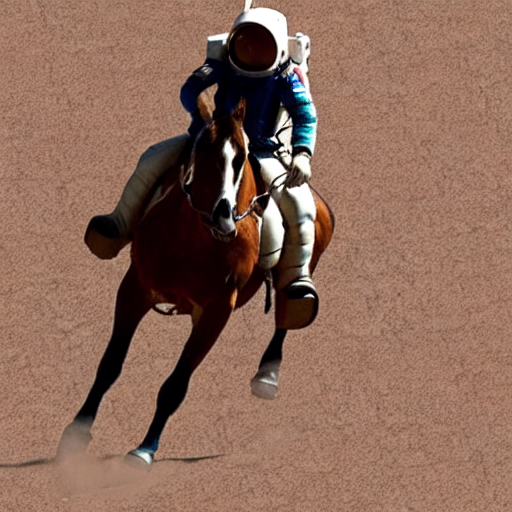

In [3]:
# Download then model
model_id = "sd-legacy/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

# Generate an image
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]

# Display image
image


We can generate better quality images by using more steps.

  0%|          | 0/5 [00:00<?, ?it/s]

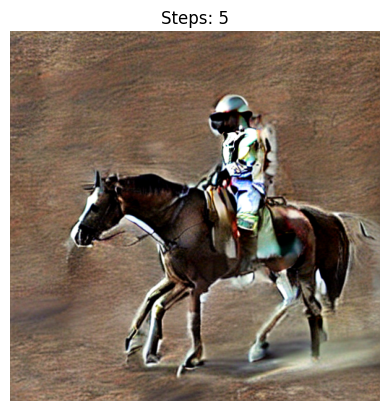

  0%|          | 0/10 [00:00<?, ?it/s]

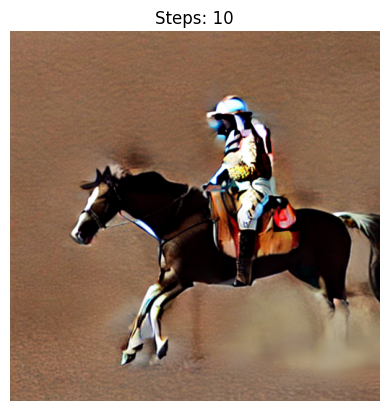

  0%|          | 0/20 [00:00<?, ?it/s]

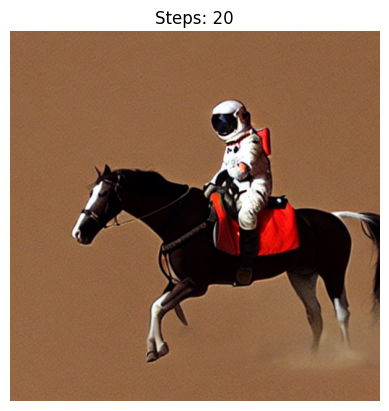

  0%|          | 0/50 [00:00<?, ?it/s]

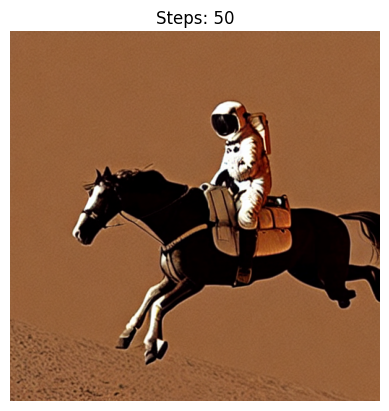

In [4]:
steps = [5,10,20,50]
for step in steps:
  # set seed
  torch.manual_seed(1)

  # Generate Image
  image = pipe(prompt, num_inference_steps=step).images[0]
  image.save(f"{step}steps.png")
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Steps: {step}")
  plt.show()

# PickScore

This model is a scoring function for images generated from text. It takes as input a prompt and a generated image and outputs a score. It can be used as a general scoring function, and for tasks such as human preference prediction, model evaluation, image ranking, and more.

In [5]:
# import
from transformers import AutoProcessor, AutoModel
from PIL import Image
import torch

# load model
device = "cuda"
processor_name_or_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
model_pretrained_name_or_path = "yuvalkirstain/PickScore_v1"

processor = AutoProcessor.from_pretrained(processor_name_or_path)
model = AutoModel.from_pretrained(model_pretrained_name_or_path).eval().to(device)

def calc_probs(prompt, images):

    # preprocess
    image_inputs = processor(
        images=images,
        padding=True,
        truncation=True,
        max_length=77,
        return_tensors="pt",
    ).to(device)

    text_inputs = processor(
        text=prompt,
        padding=True,
        truncation=True,
        max_length=77,
        return_tensors="pt",
    ).to(device)


    with torch.no_grad():
        # embed
        image_embs = model.get_image_features(**image_inputs)
        image_embs = image_embs / torch.norm(image_embs, dim=-1, keepdim=True)

        text_embs = model.get_text_features(**text_inputs)
        text_embs = text_embs / torch.norm(text_embs, dim=-1, keepdim=True)

        # score
        scores = model.logit_scale.exp() * (text_embs @ image_embs.T)[0]

        # get probabilities if you have multiple images to choose from
        probs = torch.softmax(scores, dim=-1)

    return probs.cpu().tolist()

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

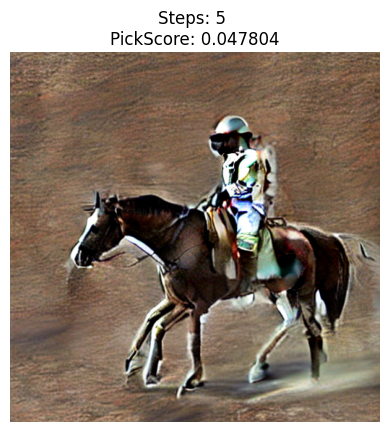

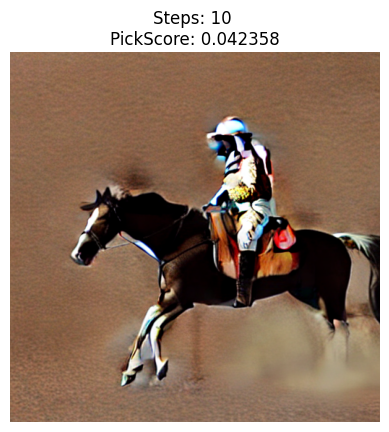

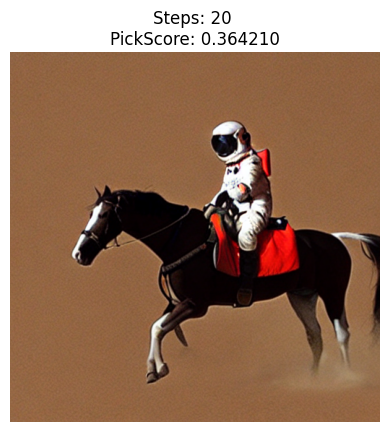

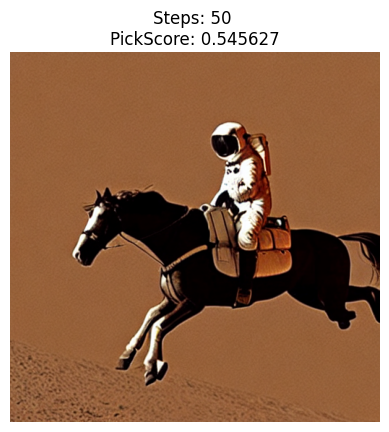

In [10]:
# Caclculate PickScore's for generated images
pil_images = [Image.open(f"{s}steps.png") for s in steps]
scores = calc_probs(prompt, pil_images)
for score, step in zip(scores, steps):
  image = Image.open(f"{step}steps.png")
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Steps: {step} \nPickScore: {score:4f}")
  plt.show()